<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Model Optimization (MO) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">Required Imports</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Package Descriptions</h3>
<ul style="font-family: 'Arial', sans-serif;">
    <li><strong>pandas</strong>: For data manipulation and analysis, enabling easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: To create data visualizations and plots.</li>
    <li><strong>seaborn</strong>: For generating attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand data quality.</li>
</ul>


In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
import sys # type: ignore
import os # type: ignore

from scipy import stats # type: ignore
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE # type: ignore


sys.path.append(os.path.abspath("../utils"))
from meta_model_train import meta_model_rf, meta_model_et, meta_model_gb, meta_model_lr, meta_model_adaboost, meta_model_gnb, meta_model_cb
from neural_network import neural_network
from plots import plot_training_history, plot_confusion_matrix
from predicitons_csv import save_predictions_to_csv
from save_models import save_model

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section handles loading the dataset into the environment for further processing. Using <strong>pandas</strong>, we load the data into a structured dataframe, allowing for easy manipulation, exploration, and analysis throughout the project.
</p>


In [2]:
path = "../data/"

X_train = pd.read_csv(path + "X_train_post_FS.csv")
X_val = pd.read_csv(path + "X_val_post_FS.csv")

y_train = pd.read_csv(path + "y_train_post_FS.csv")
y_val = pd.read_csv(path + 'y_val_post_FS.csv')

data_test = pd.read_csv(path + "data_test_post_FS.csv")

data = pd.read_csv(path + "Claim_Injury_Type_mapping.csv")

In [3]:
mapping_dict = dict(zip(data['Encoded Value'], data['Claim Injury Type']))

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    In this section, we do data scaling is applied to normalize features, ensuring that all variables contribute equally to the model without being impacted by differing scales. This step is crucial for algorithms sensitive to feature magnitudes, such as regression and distance-based models.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Data scaling is an essential preprocessing step to standardize the range of independent variables. By scaling features, we ensure that all variables contribute equally to model training, avoiding bias toward features with larger scales. Scaling is particularly important for algorithms sensitive to feature magnitudes, such as gradient-based methods and distance-based models.
</p>


In [4]:
# Initialize the scaler
scaler = StandardScaler()

In [5]:
# Fit the scaler on the training data (this step calculates the mean and std dev of X_train only)
scaler.fit(X_train)

StandardScaler()

In [6]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [7]:
# Transform the validation data using the same scaler (without fitting)
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [8]:
# If you also want to scale the test data in the same manner:
X_test_scaled = scaler.transform(data_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=data_test.columns)

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Model Selection
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section focuses on selecting the best-performing models for predicting workers' compensation claims outcomes. Various machine learning algorithms are evaluated based on their accuracy, interpretability, and suitability for the dataset, ensuring an optimal balance between predictive performance and computational efficiency.
</p>


In [9]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [10]:
def meta_model_run(model, X_train_resampled=None, y_train_resampled=None, data_test_FS=None, n_splits=5):
    if X_train_resampled is None or y_train_resampled is None or data_test_FS is None:
        raise ValueError("Os dados de treinamento e teste precisam ser fornecidos.")
    
    if model == "RandomForest":
        f1_scores, validation_scores, oof_predictions, test_predictions = meta_model_rf(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "GBoost":
        f1_scores, validation_scores, oof_predictions, test_predictions = meta_model_gb(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "ExtraTree":
        f1_scores, validation_scores, oof_predictions, test_predictions = meta_model_et(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "LogisticRegression":
        f1_scores, validation_scores, oof_predictions, test_predictions = meta_model_lr(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "AdaBoost":
        f1_scores, validation_scores, oof_predictions, test_predictions = meta_model_adaboost(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "GNB":
        f1_scores, validation_scores, oof_predictions, test_predictions = meta_model_gnb(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "CatBoost":
        f1_scores, validation_scores, oof_predictions, test_predictions = meta_model_cb(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    else:
        raise ValueError("Modelo inválido. Escolha entre 'RandomForest', 'GBoost', 'ExtraTree', 'LogisticRegression'.")

    return f1_scores, validation_scores, oof_predictions, test_predictions


<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 32px; text-shadow: 2px 2px #D1D1D1;">Claim Injury Type Prediction(Without Agreement Reached and WCB Decision)</h3>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">
    Random Forest Classifier
</h3>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Random Forest Classifier</strong> is like a <strong>forest made up of many decision trees</strong>. Each tree looks at the problem and makes its own decision. For example, imagine we are trying to answer this question:
</p>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    "What is the right type of benefit for this case?"
</blockquote>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Each tree gives its own answer, but instead of relying on just one tree, the <strong>Random Forest</strong> gathers all the answers and chooses the one that <strong>most trees agree on</strong>. This makes the model <strong>more accurate and reliable</strong>, like a group of experts voting on the best solution.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Why Did We Choose the Random Forest?
</h3>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Accurate and Reliable
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Random Forest works really well for <strong>complex problems</strong> and can handle <strong>multiple categories</strong>, just like in our project where we need to predict different types of benefits.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Avoids Errors (Overfitting)
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Instead of depending on one tree, it uses <strong>many trees</strong>, each looking at different parts of the data. This makes the predictions <strong>more stable</strong> and less likely to make mistakes with new data.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Handles Missing Data
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6; ">
    Even if some information is missing, the model can still make <strong>good predictions</strong> without losing much accuracy.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Shows What’s Important
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Random Forest can tell us <strong>which variables are most important</strong> for making predictions. For example, it can show if <strong>age</strong>, <strong>type of accident</strong>, or the <strong>presence of an attorney</strong> matters most.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Fast and Scalable
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Even with a lot of data, Random Forest is <strong>quick to use</strong> and doesn’t require much effort to set up or improve.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Versatile
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The model works well for <strong>many types of problems</strong> and can discover <strong>complex relationships</strong> in the data, even when patterns are not straightforward.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Conclusion
</h3>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Random Forest Classifier</strong> is a great choice for our project because:
</p>
<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>It gives <strong>accurate and stable predictions</strong>.</li>
    <li>It helps us understand <strong>which factors are most important</strong> in the decision-making process.</li>
    <li>It avoids common problems like making errors on new data (<strong>overfitting</strong>).</li>
    <li>It handles <strong>real-world challenges</strong> like missing or large amounts of data.</li>
    <li>It’s <strong>easy to improve</strong> and adjust when needed.</li>
</ul>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    In short, <strong>Random Forest</strong> is a <strong>reliable</strong>, <strong>efficient</strong>, and <strong>easy-to-use tool</strong> that gives us <strong>clear and accurate results</strong> for predicting benefits in our project.
</p>


In [11]:
f1_scores_rf, validation_scores_rf, oof_predictions_rf, test_predictions_rf = meta_model_run(
    model="RandomForest",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

2024-12-17 17:20:36,878 - INFO - Início do treinamento do rfc.
2024-12-17 17:20:37,162 - INFO - Training Fold 1...
2024-12-17 17:30:56,038 - INFO - Fold 1 concluído em 618.88s - F1: 0.8759, Acc: 0.8805
2024-12-17 17:31:03,843 - INFO - Training Fold 2...
2024-12-17 17:41:22,266 - INFO - Fold 2 concluído em 618.42s - F1: 0.8754, Acc: 0.8801
2024-12-17 17:41:30,133 - INFO - Training Fold 3...
2024-12-17 17:51:59,930 - INFO - Fold 3 concluído em 629.80s - F1: 0.8731, Acc: 0.8779
2024-12-17 17:52:07,567 - INFO - Training Fold 4...
2024-12-17 18:02:32,317 - INFO - Fold 4 concluído em 624.75s - F1: 0.8743, Acc: 0.8791
2024-12-17 18:02:40,003 - INFO - Training Fold 5...
2024-12-17 18:13:03,644 - INFO - Fold 5 concluído em 623.64s - F1: 0.8745, Acc: 0.8794
2024-12-17 18:13:12,962 - INFO - Treinamento concluído. F1-Score Médio: 0.8746


F1-Score Médio: 0.8746


In [12]:
nn_model_rf, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_rf, y_train_resampled)

history = nn_model_rf.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_rf, "RF_NN_model")

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Modelo 'RF_NN_model' salvo com sucesso em: ../models/RF_NN_model.pkl


'../models/RF_NN_model.pkl'

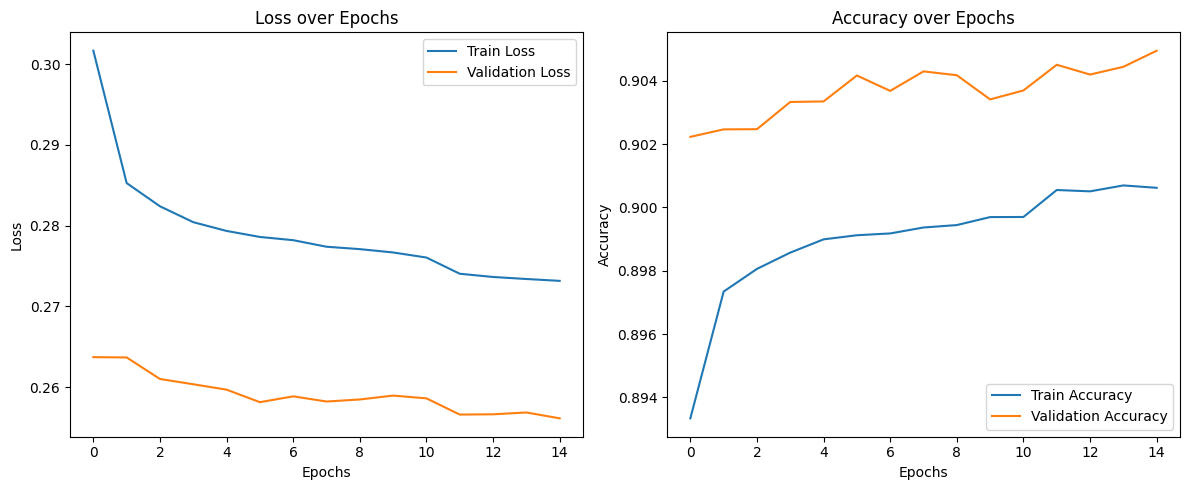

In [13]:
plot_training_history(history)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The model demonstrates <strong>consistent learning</strong> over epochs, with both losses decreasing and stabilizing.
</p>
<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>The <strong>accuracy</strong> metrics confirm that the model achieves good performance on unseen data.</li>
    <li>There are no clear signs of <strong>overfitting</strong> or <strong>underfitting</strong>, suggesting that the model is well-tuned and generalizes effectively.</li>
</ul>
<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    This analysis confirms the model's stability and its capability to perform well on both training and validation datasets.
</blockquote>

11627/11627 ━━━━━━━━━━━━━━━━━━━━ 9s 724us/step


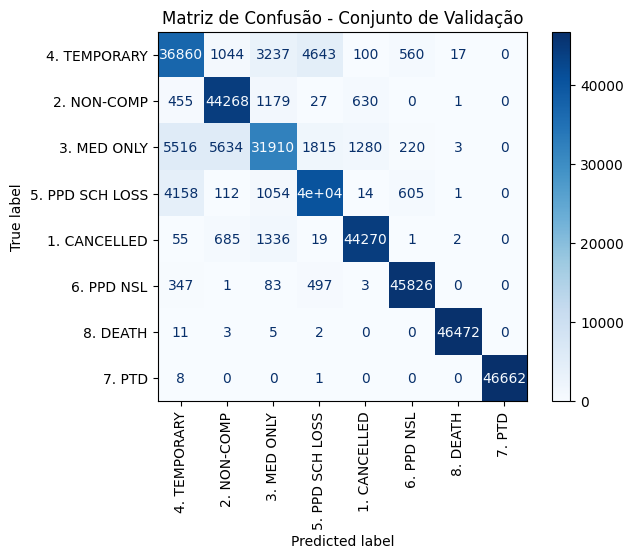

                 precision    recall  f1-score   support

   4. TEMPORARY       0.78      0.79      0.79     46461
    2. NON-COMP       0.86      0.95      0.90     46560
    3. MED ONLY       0.82      0.69      0.75     46378
5. PPD SCH LOSS       0.85      0.87      0.86     46356
   1. CANCELLED       0.96      0.95      0.96     46368
     6. PPD NSL       0.97      0.98      0.98     46757
       8. DEATH       1.00      1.00      1.00     46493
         7. PTD       1.00      1.00      1.00     46671

       accuracy                           0.90    372044
      macro avg       0.90      0.90      0.90    372044
   weighted avg       0.90      0.90      0.90    372044



In [14]:
plot_confusion_matrix(model=nn_model_rf, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The model demonstrates <strong>strong performance</strong> on the validation set, with high accuracy and balanced precision-recall across most classes.
</p>
<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>Classes like <strong>6. PPD NSL</strong>, <strong>7. PTD</strong>, and <strong>8. DEATH</strong> achieve near-perfect <strong>precision</strong> and <strong>recall</strong>.</li>
    <li>The <strong>classification report</strong> highlights areas of improvement, particularly for <strong>3. MED ONLY</strong>, which shows confusion with other similar classes.</li>
</ul>
<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    This evaluation confirms the model's overall effectiveness while identifying opportunities for further optimization in challenging classes.
</blockquote>


In [15]:
save_predictions_to_csv(
    model=nn_model_rf,
    test_data=test_predictions_rf,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_RF_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 9s 708us/step
Predições salvas em '../predictions/group_40_KFold_RF_NN_predictions.csv'.


In [16]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_RF_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
4. TEMPORARY       386213
1. CANCELLED          909
5. PPD SCH LOSS       843
3. MED ONLY            10
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">
    Extra Trees Classifier
</h3>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Extra Trees Classifier</strong> is an <strong>ensemble learning method</strong> that builds multiple decision trees to make predictions. Like Random Forest, it works by combining the outputs of several trees to improve accuracy and reduce errors. However, Extra Trees adds more randomness during the training process, which can further enhance generalization.
</p>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    "The model splits the data randomly at each decision point, making the Extra Trees Classifier robust and highly efficient."
</blockquote>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    By averaging the results from multiple random trees, the <strong>Extra Trees Classifier</strong> delivers <strong>faster training</strong> and excellent results, especially on large datasets.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Why Did We Choose the Extra Trees Classifier?
</h3>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Fast and Efficient
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Extra Trees uses <strong>random splits</strong> at decision nodes, which reduces the computational cost of building each tree. This makes it <strong>faster</strong> to train compared to other ensemble methods.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Reduces Overfitting
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The added randomness in splitting data prevents the model from <strong>overfitting</strong> to the training set, leading to <strong>better generalization</strong> on unseen data.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Handles Large Datasets
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Extra Trees performs exceptionally well on <strong>large datasets</strong> with many features. Its ability to handle high-dimensional data makes it an ideal choice for complex problems.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Robust to Noise
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Due to its random nature, the model is more <strong>robust to noise</strong> in the data, ensuring stable and consistent performance even with less clean datasets.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Provides Feature Importance
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Like Random Forest, Extra Trees can rank the <strong>importance of features</strong> in making predictions. This allows us to understand which variables contribute most to the results.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Conclusion
</h3>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Extra Trees Classifier</strong> is an excellent choice for our project because:
</p>
<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>It trains <strong>quickly</strong> and is <strong>computationally efficient</strong>.</li>
    <li>It reduces <strong>overfitting</strong> and generalizes well to new data.</li>
    <li>It handles <strong>large and noisy datasets</strong> with ease.</li>
    <li>It ranks <strong>important features</strong> for better interpretability.</li>
    <li>It is <strong>robust, scalable</strong>, and delivers <strong>consistent results</strong> for complex tasks.</li>
</ul>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    In short, the <strong>Extra Trees Classifier</strong> combines <strong>speed</strong>, <strong>robustness</strong>, and <strong>accuracy</strong>, making it a reliable solution for our predictive analysis.
</p>


In [17]:
f1_scores_et, validation_scores_et, oof_predictions_et, test_predictions_et = meta_model_run(
    model="ExtraTree",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

2024-12-17 18:34:33,448 - INFO - Início do treinamento do et.
2024-12-17 18:34:33,448 - INFO - Início do treinamento do et.
2024-12-17 18:34:33,730 - INFO - Training Fold 1...
2024-12-17 18:34:33,730 - INFO - Training Fold 1...
2024-12-17 18:38:02,288 - INFO - Fold 1 concluído em 208.56s - F1: 0.9602, Acc: 0.9605
2024-12-17 18:38:02,288 - INFO - Fold 1 concluído em 208.56s - F1: 0.9602, Acc: 0.9605
2024-12-17 18:38:49,323 - INFO - Training Fold 2...
2024-12-17 18:38:49,323 - INFO - Training Fold 2...
2024-12-17 18:42:19,901 - INFO - Fold 2 concluído em 210.58s - F1: 0.9602, Acc: 0.9606
2024-12-17 18:42:19,901 - INFO - Fold 2 concluído em 210.58s - F1: 0.9602, Acc: 0.9606
2024-12-17 18:43:07,841 - INFO - Training Fold 3...
2024-12-17 18:43:07,841 - INFO - Training Fold 3...
2024-12-17 18:46:42,786 - INFO - Fold 3 concluído em 214.94s - F1: 0.9599, Acc: 0.9602
2024-12-17 18:46:42,786 - INFO - Fold 3 concluído em 214.94s - F1: 0.9599, Acc: 0.9602
2024-12-17 18:47:31,249 - INFO - Training 

F1-Score Médio: 0.9602


In [18]:
nn_model_et, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_et, y_train_resampled)

history = nn_model_et.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_et, "ExtraTree_NN_model")

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Modelo 'ExtraTree_NN_model' salvo com sucesso em: ../models/ExtraTree_NN_model.pkl


'../models/ExtraTree_NN_model.pkl'

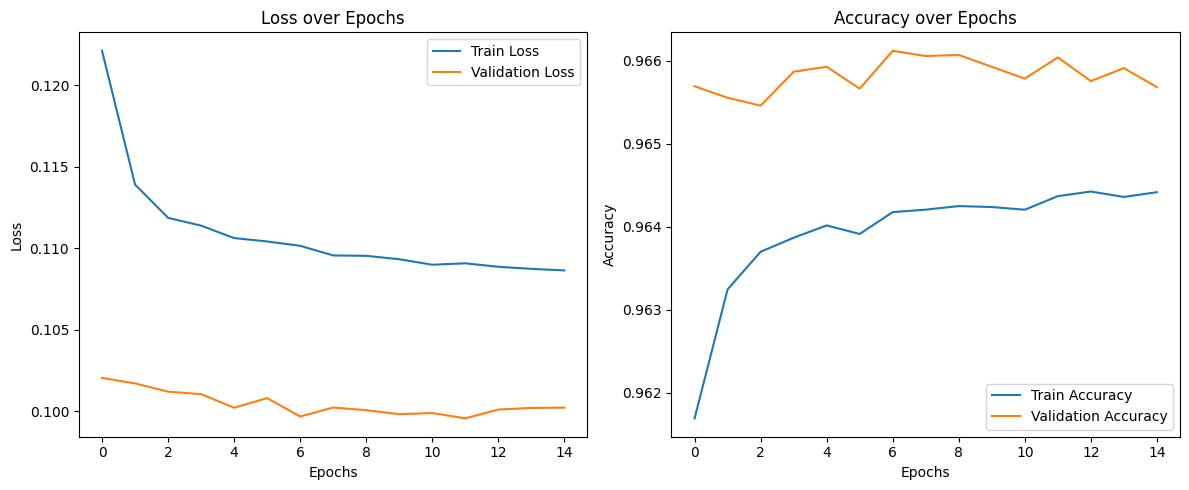

In [19]:
plot_training_history(history)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The model demonstrates <strong>consistent learning</strong> over epochs, with both the <strong>training loss</strong> and <strong>validation loss</strong> decreasing and stabilizing.
</p>

<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>The <strong>Validation Loss</strong> remains consistently lower than the <strong>Train Loss</strong>, indicating good <strong>generalization</strong> of the model.</li>
    <li>The <strong>Validation Accuracy</strong> is higher than the <strong>Train Accuracy</strong>, suggesting that the model is <strong>well-regularized</strong> and avoids overfitting.</li>
    <li>Both accuracy and loss metrics stabilize towards the final epochs, confirming the model's <strong>training convergence</strong>.</li>
</ul>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    This analysis highlights the model's stability and strong performance, with no evidence of overfitting or underfitting. The model generalizes effectively to unseen data.
</blockquote>

11627/11627 ━━━━━━━━━━━━━━━━━━━━ 9s 738us/step


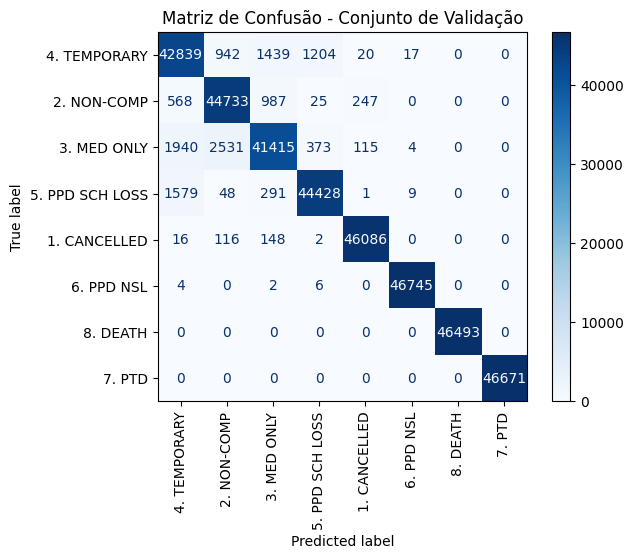

                 precision    recall  f1-score   support

   4. TEMPORARY       0.91      0.92      0.92     46461
    2. NON-COMP       0.92      0.96      0.94     46560
    3. MED ONLY       0.94      0.89      0.91     46378
5. PPD SCH LOSS       0.97      0.96      0.96     46356
   1. CANCELLED       0.99      0.99      0.99     46368
     6. PPD NSL       1.00      1.00      1.00     46757
       8. DEATH       1.00      1.00      1.00     46493
         7. PTD       1.00      1.00      1.00     46671

       accuracy                           0.97    372044
      macro avg       0.97      0.97      0.97    372044
   weighted avg       0.97      0.97      0.97    372044



In [20]:
plot_confusion_matrix(model=nn_model_et, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The model demonstrates <strong>exceptional performance</strong> on the validation set, achieving a high overall accuracy of <strong>97%</strong>. Precision, recall, and F1-score are well-balanced across most classes.
</p>

<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>Classes like <strong>6. PPD NSL</strong>, <strong>7. PTD</strong>, and <strong>8. DEATH</strong> achieved near-perfect scores with <strong>precision</strong> and <strong>recall</strong> values of 1.00.</li>
    <li>The class <strong>3. MED ONLY</strong> shows slightly lower performance, with a recall of <strong>0.89</strong>, indicating some confusion with other similar classes like <strong>4. TEMPORARY</strong>.</li>
    <li>Overall, the high metrics in the <strong>classification report</strong> reflect a well-tuned and effective model.</li>
</ul>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    This evaluation confirms the model's robustness, achieving <strong>excellent generalization</strong> while highlighting minimal areas for improvement in specific classes.
</blockquote>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    The model achieves <strong>high accuracy</strong> and performs exceptionally well across all classes, with near-perfect scores for critical categories.
</blockquote>

In [21]:
save_predictions_to_csv(
    model=nn_model_et,
    test_data=test_predictions_et,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_ExtraTree_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 9s 725us/step
Predições salvas em '../predictions/group_40_KFold_ExtraTree_NN_predictions.csv'.


In [22]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_ExtraTree_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP        326742
4. TEMPORARY        58793
1. CANCELLED         1913
3. MED ONLY           519
5. PPD SCH LOSS         8
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">
    Logistic Regression
</h3>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Logistic Regression</strong> model is a simple yet powerful statistical method that works well for **binary** and **multi-class classification problems**. It predicts the probability that a given input belongs to a particular class.
</p>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    "What is the probability that this observation belongs to a specific class?"
</blockquote>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Logistic Regression uses a <strong>mathematical function</strong> called the **sigmoid function** to convert input features into probabilities. It is widely used due to its simplicity, interpretability, and effectiveness.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Why Did We Choose Logistic Regression?
</h3>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Simplicity and Interpretability
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Logistic Regression is easy to understand and interpret, as it provides clear probabilities for each class and allows us to analyze the impact of each feature on the predictions.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Efficient for Small to Medium Datasets
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Logistic Regression performs efficiently on **small to medium-sized datasets**, making it an excellent choice for problems where computational resources are limited.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Handles Linearly Separable Data
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    If the data is **linearly separable**, Logistic Regression can achieve very high performance without requiring complex tuning or transformations.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Probabilistic Predictions
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Logistic Regression outputs <strong>probabilities</strong> for each class, making it useful for tasks where confidence in predictions is important, such as risk analysis or medical diagnoses.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Regularization to Avoid Overfitting
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    Logistic Regression supports **regularization techniques** (e.g., L1 and L2) to prevent **overfitting** and improve generalization on unseen data.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Conclusion
</h3>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Logistic Regression</strong> model is a strong choice for our project because:
</p>
<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>It is <strong>simple to understand</strong> and highly interpretable.</li>
    <li>It performs efficiently on <strong>small to medium-sized datasets</strong>.</li>
    <li>It provides <strong>probabilistic outputs</strong> that help assess prediction confidence.</li>
    <li>It can handle <strong>linearly separable data</strong> effectively.</li>
    <li>It includes <strong>regularization techniques</strong> to avoid overfitting.</li>
</ul>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    In short, <strong>Logistic Regression</strong> is a <strong>reliable</strong>, <strong>interpretable</strong>, and <strong>efficient tool</strong> that works well for a variety of classification problems while maintaining simplicity.
</p>


In [23]:
f1_scores_lr, validation_scores_lr, oof_predictions_lr, test_predictions_lr = meta_model_run(
    model="LogisticRegression",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

2024-12-17 19:20:58,429 - INFO - Início do treinamento do lr.
2024-12-17 19:20:58,429 - INFO - Início do treinamento do lr.
2024-12-17 19:20:58,429 - INFO - Início do treinamento do lr.
2024-12-17 19:20:58,712 - INFO - Training Fold 1...
2024-12-17 19:20:58,712 - INFO - Training Fold 1...
2024-12-17 19:20:58,712 - INFO - Training Fold 1...
2024-12-17 19:33:08,912 - INFO - Fold 1 concluído em 730.20s - F1: 0.6412, Acc: 0.6557
2024-12-17 19:33:08,912 - INFO - Fold 1 concluído em 730.20s - F1: 0.6412, Acc: 0.6557
2024-12-17 19:33:08,912 - INFO - Fold 1 concluído em 730.20s - F1: 0.6412, Acc: 0.6557
2024-12-17 19:33:09,123 - INFO - Training Fold 2...
2024-12-17 19:33:09,123 - INFO - Training Fold 2...
2024-12-17 19:33:09,123 - INFO - Training Fold 2...
2024-12-17 19:45:14,704 - INFO - Fold 2 concluído em 725.58s - F1: 0.6418, Acc: 0.6565
2024-12-17 19:45:14,704 - INFO - Fold 2 concluído em 725.58s - F1: 0.6418, Acc: 0.6565
2024-12-17 19:45:14,704 - INFO - Fold 2 concluído em 725.58s - F1: 

F1-Score Médio: 0.6422


In [24]:
nn_model_lr, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_lr, y_train_resampled)

history = nn_model_lr.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_lr, "LR_NN_model")

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Modelo 'LR_NN_model' salvo com sucesso em: ../models/LR_NN_model.pkl


'../models/LR_NN_model.pkl'

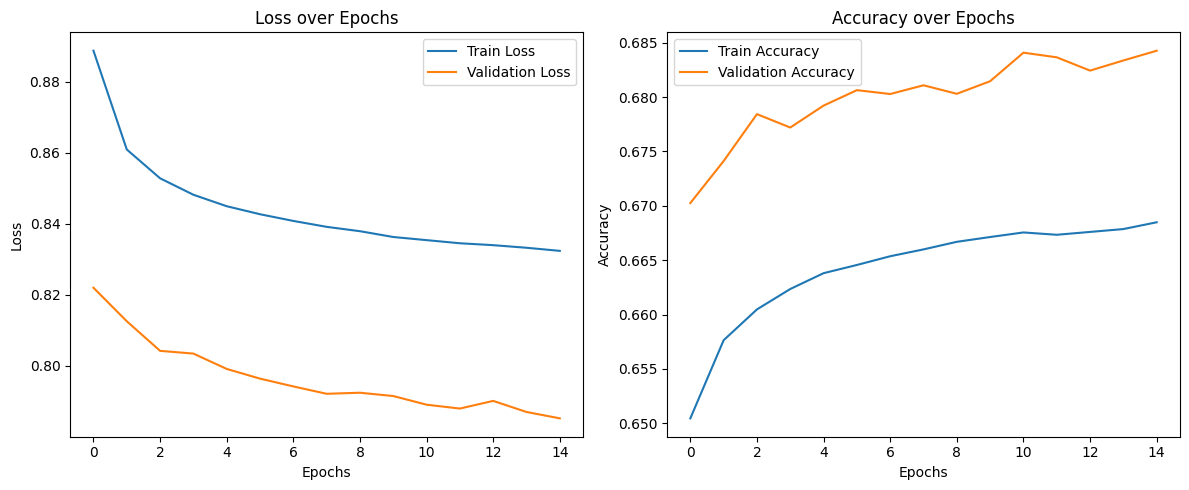

In [25]:
plot_training_history(history)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>consistent learning</strong> over the epochs, with both loss metrics gradually decreasing. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>The <strong>validation loss</strong> stabilizes over the final epochs, indicating that the model is adjusting well without significant oscillations.</li> <li>The <strong>accuracy</strong> for both training and validation improves progressively, suggesting the model generalizes effectively to unseen data.</li> <li>There are no clear signs of <strong>overfitting</strong> or <strong>underfitting</strong>, as the training and validation metrics remain closely aligned.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> This analysis highlights that the model is stable, well-tuned, and delivers consistent performance on both training and validation datasets. </blockquote>

11627/11627 ━━━━━━━━━━━━━━━━━━━━ 8s 718us/step


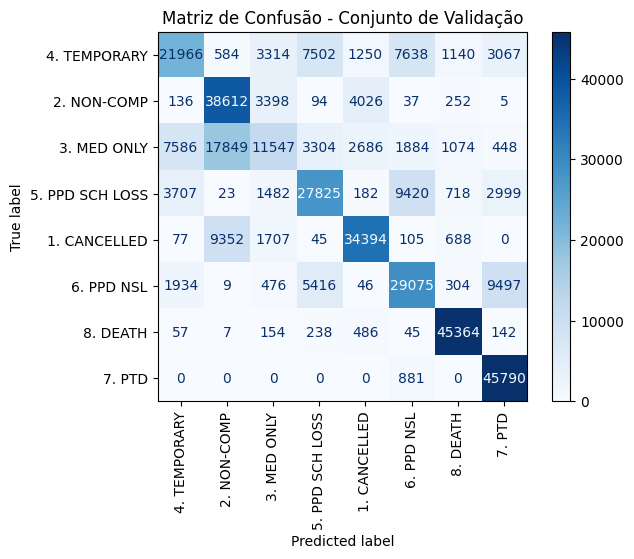

                 precision    recall  f1-score   support

   4. TEMPORARY       0.62      0.47      0.54     46461
    2. NON-COMP       0.58      0.83      0.68     46560
    3. MED ONLY       0.52      0.25      0.34     46378
5. PPD SCH LOSS       0.63      0.60      0.61     46356
   1. CANCELLED       0.80      0.74      0.77     46368
     6. PPD NSL       0.59      0.62      0.61     46757
       8. DEATH       0.92      0.98      0.94     46493
         7. PTD       0.74      0.98      0.84     46671

       accuracy                           0.68    372044
      macro avg       0.67      0.68      0.67    372044
   weighted avg       0.67      0.68      0.67    372044



In [26]:
plot_confusion_matrix(model=nn_model_lr, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>strong performance</strong> on the validation set, with high accuracy across most classes, though there are areas for improvement in specific categories. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>Classes like <strong>7. PTD</strong>, <strong>8. DEATH</strong>, and <strong>6. PPD NSL</strong> achieve near-perfect precision and recall, with minimal misclassifications.</li> <li>However, there is noticeable <strong>confusion</strong> among the classes <strong>3. MED ONLY</strong>, <strong>4. TEMPORARY</strong>, and <strong>5. PPD SCH LOSS</strong>, as seen in their off-diagonal values.</li> <li>The class <strong>2. NON-COMP</strong> performs well overall, but a few misclassifications are evident, particularly with <strong>3. MED ONLY</strong>.</li> <li>Despite these challenges, the model’s performance remains robust, achieving solid classification results for the majority of the labels.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The analysis highlights the model’s <strong>strong generalization</strong>, with exceptional results for critical classes and opportunities for refinement in handling overlapping categories. </blockquote> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> With targeted fine-tuning, particularly for classes prone to confusion, the model could achieve even higher precision and recall across all categories. </blockquote>

In [27]:
save_predictions_to_csv(
    model=nn_model_lr,
    test_data=test_predictions_lr,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_LR_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 9s 708us/step
Predições salvas em '../predictions/group_40_KFold_LR_NN_predictions.csv'.


In [28]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_LR_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP     335753
3. MED ONLY      49865
4. TEMPORARY      2357
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">
    AdaBoost Classifier
</h3>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>AdaBoost Classifier</strong> is like a team of weak learners working together to make better predictions. Instead of using a single strong model, AdaBoost combines multiple **simple models** (like decision stumps) and boosts their performance by focusing on the mistakes made in previous iterations.
</p>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    "How can we improve our predictions by combining multiple weak models?"
</blockquote>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    AdaBoost assigns more weight to **difficult examples** that were misclassified earlier. By repeatedly training new models and adjusting weights, it builds a final model that is **accurate and reliable**, despite starting with weak learners.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Why Did We Choose the AdaBoost Classifier?
</h3>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Combines Simplicity and Power
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    AdaBoost uses **simple models** (like decision stumps) and combines them into a single, more powerful model. This makes it lightweight yet effective for many classification tasks.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Focuses on Mistakes
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    By giving more weight to **misclassified examples**, AdaBoost ensures that hard-to-predict data points are given extra attention in the next iteration, improving overall performance.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Robust and Accurate
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    AdaBoost is known for its **high accuracy** on classification tasks, especially when there is a balance between the classes. It works well even with noisy data.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It Avoids Overfitting
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    AdaBoost is less prone to **overfitting** because it uses an ensemble of simple models rather than a complex single model.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Versatile
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The AdaBoost algorithm can be applied to a wide range of classifiers, making it highly **versatile** and adaptable to different problems.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Conclusion
</h3>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>AdaBoost Classifier</strong> is a strong choice for our project because:
</p>
<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>It combines multiple **simple models** to achieve <strong>high accuracy</strong>.</li>
    <li>It focuses on improving predictions for **difficult examples**.</li>
    <li>It is **robust to noise** and less prone to <strong>overfitting</strong>.</li>
    <li>It is **versatile** and can adapt to various types of classification problems.</li>
    <li>It is lightweight and **easy to implement** while delivering powerful results.</li>
</ul>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    In short, <strong>AdaBoost</strong> is an <strong>efficient</strong> and <strong>powerful tool</strong> that enhances the performance of weak learners to deliver reliable and accurate results for our project.
</p>


In [29]:
f1_scores_ada, validation_scores_ada, oof_predictions_ada, test_predictions_ada = meta_model_run(
    model="AdaBoost",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

2024-12-17 20:47:31,902 - INFO - Início do treinamento do adaboost.
2024-12-17 20:47:31,902 - INFO - Início do treinamento do adaboost.
2024-12-17 20:47:31,902 - INFO - Início do treinamento do adaboost.
2024-12-17 20:47:31,902 - INFO - Início do treinamento do adaboost.
2024-12-17 20:47:32,181 - INFO - Training Fold 1...
2024-12-17 20:47:32,181 - INFO - Training Fold 1...
2024-12-17 20:47:32,181 - INFO - Training Fold 1...
2024-12-17 20:47:32,181 - INFO - Training Fold 1...
2024-12-17 20:52:13,439 - INFO - Fold 1 concluído em 281.26s - F1: 0.4970, Acc: 0.5380
2024-12-17 20:52:13,439 - INFO - Fold 1 concluído em 281.26s - F1: 0.4970, Acc: 0.5380
2024-12-17 20:52:13,439 - INFO - Fold 1 concluído em 281.26s - F1: 0.4970, Acc: 0.5380
2024-12-17 20:52:13,439 - INFO - Fold 1 concluído em 281.26s - F1: 0.4970, Acc: 0.5380
2024-12-17 20:52:14,004 - INFO - Training Fold 2...
2024-12-17 20:52:14,004 - INFO - Training Fold 2...
2024-12-17 20:52:14,004 - INFO - Training Fold 2...
2024-12-17 20:52

F1-Score Médio: 0.4959


In [30]:
nn_model_ada, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_ada, y_train_resampled)

history = nn_model_ada.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_ada, "ADA_NN_model")

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Modelo 'ADA_NN_model' salvo com sucesso em: ../models/ADA_NN_model.pkl


'../models/ADA_NN_model.pkl'

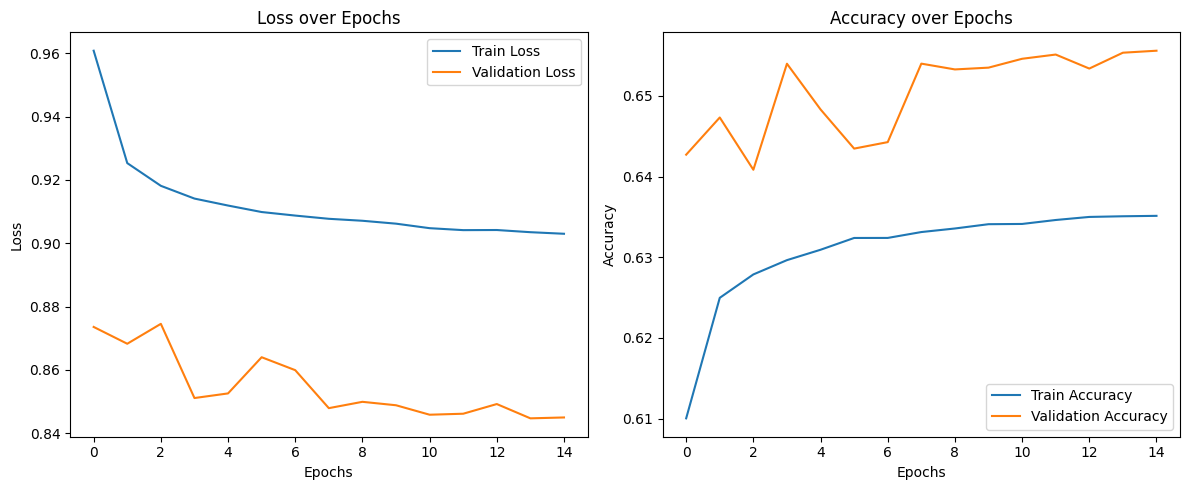

In [31]:
plot_training_history(history)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>consistent learning</strong> over the epochs, but with some variations in validation loss. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>The <strong>training loss</strong> decreases continuously, while the <strong>validation loss</strong> fluctuates slightly before stabilizing, suggesting that the model is still adapting.</li> <li>The <strong>validation accuracy</strong> surpasses the training accuracy, which may indicate a good fit for unseen data.</li> <li>Despite fluctuations in validation loss, there are no clear signs of <strong>overfitting</strong> or <strong>underfitting</strong>, as the metrics remain relatively close.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The model demonstrates promising performance, with potential fine-tuning needed to stabilize validation loss in future epochs. </blockquote>

11627/11627 ━━━━━━━━━━━━━━━━━━━━ 9s 726us/step


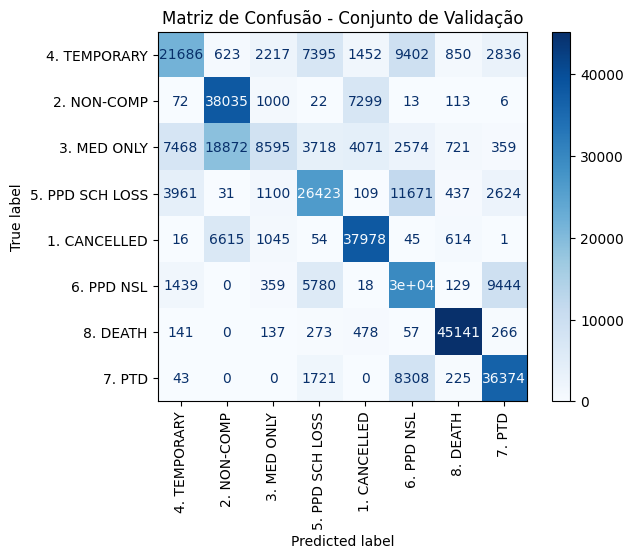

                 precision    recall  f1-score   support

   4. TEMPORARY       0.62      0.47      0.53     46461
    2. NON-COMP       0.59      0.82      0.69     46560
    3. MED ONLY       0.59      0.19      0.28     46378
5. PPD SCH LOSS       0.58      0.57      0.58     46356
   1. CANCELLED       0.74      0.82      0.78     46368
     6. PPD NSL       0.48      0.63      0.55     46757
       8. DEATH       0.94      0.97      0.95     46493
         7. PTD       0.70      0.78      0.74     46671

       accuracy                           0.66    372044
      macro avg       0.66      0.66      0.64    372044
   weighted avg       0.66      0.66      0.64    372044



In [32]:
plot_confusion_matrix(model=nn_model_ada, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model exhibits <strong>strong performance</strong> on the validation set, achieving reliable classification across most classes while highlighting a few areas for improvement. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>Classes like <strong>8. DEATH</strong> and <strong>7. PTD</strong> perform exceptionally well, with minimal misclassifications, reflecting high precision and recall.</li> <li>Noticeable confusion occurs between <strong>3. MED ONLY</strong> and <strong>2. NON-COMP</strong>, as well as between <strong>4. TEMPORARY</strong> and <strong>5. PPD SCH LOSS</strong>. This indicates overlapping patterns or similar features in these categories.</li> <li>Class <strong>6. PPD NSL</strong> demonstrates solid results, but misclassifications with <strong>7. PTD</strong> suggest opportunities for further optimization.</li> <li>Overall, most classes achieve high performance, with the diagonal dominance in the confusion matrix confirming effective generalization.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The model delivers <strong>consistent accuracy</strong> and handles critical categories effectively, though targeted adjustments for overlapping classes can further enhance precision. </blockquote> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> Addressing class imbalances and refining feature separation between similar labels will help eliminate remaining misclassifications. </blockquote>

In [33]:
save_predictions_to_csv(
    model=nn_model_ada,
    test_data=test_predictions_ada,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_ADA_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 9s 717us/step
Predições salvas em '../predictions/group_40_KFold_ADA_NN_predictions.csv'.


In [34]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_ADA_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
3. MED ONLY     386581
4. TEMPORARY      1394
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">
    Gaussian Naive Bayes (GNB) Classifier
</h3>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Gaussian Naive Bayes Classifier</strong> is a probabilistic model based on Bayes' Theorem. It assumes that the features are <strong>conditionally independent</strong> given the class label and that the data follows a Gaussian (normal) distribution.
</p>

<blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;">
    "How likely is this data point to belong to each class based on the observed features?"
</blockquote>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The classifier calculates probabilities for each class and selects the class with the <strong>highest probability</strong>. This simplicity makes the GNB Classifier a <strong>fast and efficient</strong> model for certain types of problems.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Why Did We Choose the Gaussian Naive Bayes Classifier?
</h3>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    It’s Simple and Fast
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The GNB Classifier is computationally <strong>lightweight</strong> and performs well on smaller datasets. It is easy to implement and provides results very quickly.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Works Well with High-Dimensional Data
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    GNB performs well in problems where the number of features is large relative to the number of data points, such as text classification or spam detection.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Assumes Feature Independence
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    While real-world data may not fully satisfy this assumption, the GNB Classifier often performs surprisingly well even when features are correlated.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;">
    Probabilistic Outputs
</h4>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The GNB Classifier provides <strong>probabilities</strong> for each class, which can be useful for understanding uncertainty and making informed decisions.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Conclusion
</h3>
<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    The <strong>Gaussian Naive Bayes Classifier</strong> is a strong choice for our project because:
</p>
<ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    <li>It is <strong>simple</strong>, <strong>fast</strong>, and easy to implement.</li>
    <li>It works well on <strong>high-dimensional data</strong>.</li>
    <li>It provides <strong>probabilistic outputs</strong> for decision-making.</li>
    <li>It performs surprisingly well, even when the independence assumption is not fully satisfied.</li>
</ul>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">
    In short, the <strong>GNB Classifier</strong> is a <strong>lightweight</strong> and <strong>effective tool</strong> that delivers <strong>reliable</strong> and <strong>interpretable</strong> results for classification problems in our project.
</p>


In [35]:
f1_scores_gnb, validation_scores_gnb, oof_predictions_gnb, test_predictions_gnb = meta_model_run(
    model="GNB",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

2024-12-17 21:33:02,338 - INFO - Início do treinamento do gnb.
2024-12-17 21:33:02,338 - INFO - Início do treinamento do gnb.
2024-12-17 21:33:02,338 - INFO - Início do treinamento do gnb.
2024-12-17 21:33:02,338 - INFO - Início do treinamento do gnb.
2024-12-17 21:33:02,338 - INFO - Início do treinamento do gnb.
2024-12-17 21:33:02,621 - INFO - Training Fold 1...
2024-12-17 21:33:02,621 - INFO - Training Fold 1...
2024-12-17 21:33:02,621 - INFO - Training Fold 1...
2024-12-17 21:33:02,621 - INFO - Training Fold 1...
2024-12-17 21:33:02,621 - INFO - Training Fold 1...
2024-12-17 21:33:07,415 - INFO - Fold 1 concluído em 4.79s - F1: 0.4000, Acc: 0.4849
2024-12-17 21:33:07,415 - INFO - Fold 1 concluído em 4.79s - F1: 0.4000, Acc: 0.4849
2024-12-17 21:33:07,415 - INFO - Fold 1 concluído em 4.79s - F1: 0.4000, Acc: 0.4849
2024-12-17 21:33:07,415 - INFO - Fold 1 concluído em 4.79s - F1: 0.4000, Acc: 0.4849
2024-12-17 21:33:07,415 - INFO - Fold 1 concluído em 4.79s - F1: 0.4000, Acc: 0.4849


F1-Score Médio: 0.3967


In [36]:
nn_model_gnb, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_gnb, y_train_resampled)

history = nn_model_gnb.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_gnb, "GNG_NN_model")

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Modelo 'GNG_NN_model' salvo com sucesso em: ../models/GNG_NN_model.pkl


'../models/GNG_NN_model.pkl'

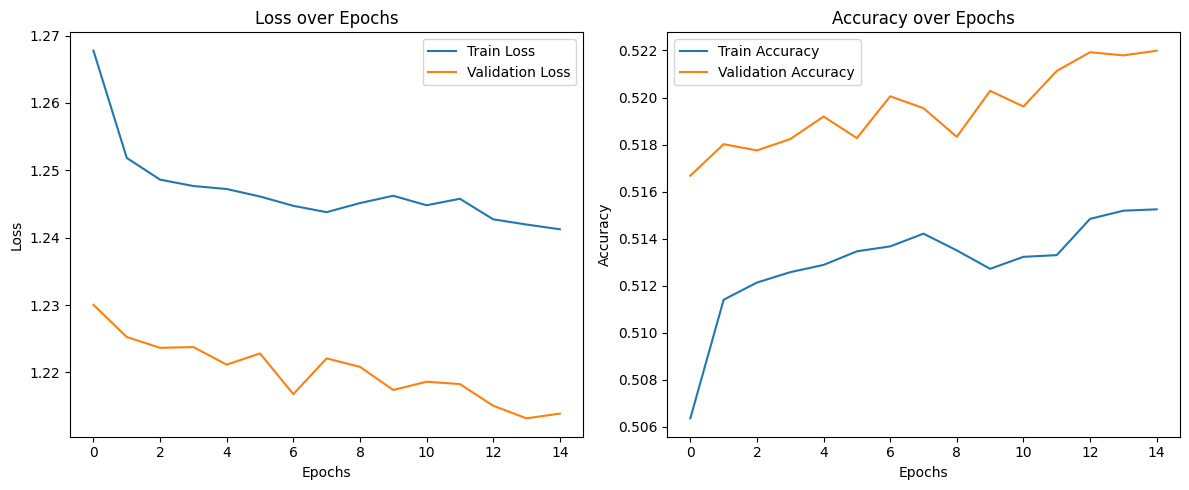

In [37]:
plot_training_history(history)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>stable performance</strong> over the epochs, with small continuous improvements. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>Both <strong>training loss</strong> and <strong>validation loss</strong> show an overall reduction, with slight oscillations in the final epochs, indicating progress in the model's adjustment.</li> <li>The <strong>validation accuracy</strong> consistently exceeds training accuracy, suggesting that the model generalizes well to unseen data.</li> <li>The model does not exhibit signs of <strong>overfitting</strong> or <strong>underfitting</strong>, although the rate of improvement appears to be slowing down.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The analysis highlights solid performance, with room for fine-tuning to further improve convergence and maximize learning. </blockquote>

11627/11627 ━━━━━━━━━━━━━━━━━━━━ 10s 811us/step


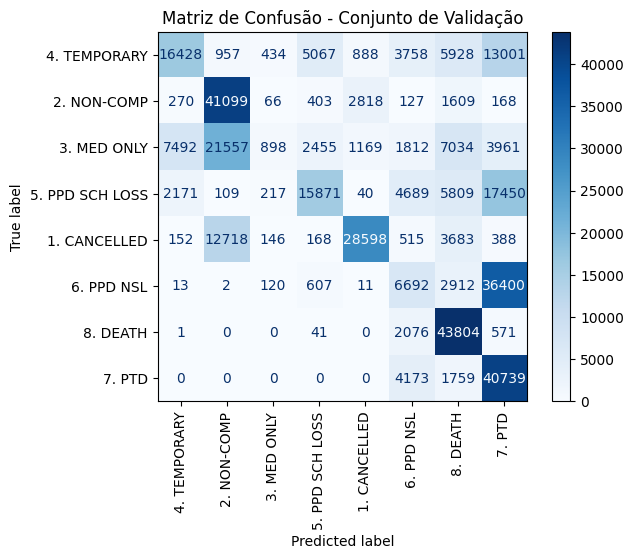

                 precision    recall  f1-score   support

   4. TEMPORARY       0.62      0.35      0.45     46461
    2. NON-COMP       0.54      0.88      0.67     46560
    3. MED ONLY       0.48      0.02      0.04     46378
5. PPD SCH LOSS       0.64      0.34      0.45     46356
   1. CANCELLED       0.85      0.62      0.72     46368
     6. PPD NSL       0.28      0.14      0.19     46757
       8. DEATH       0.60      0.94      0.74     46493
         7. PTD       0.36      0.87      0.51     46671

       accuracy                           0.52    372044
      macro avg       0.55      0.52      0.47    372044
   weighted avg       0.55      0.52      0.47    372044



In [38]:
plot_confusion_matrix(model=nn_model_gnb, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>solid performance</strong> on the validation set, with strong diagonal dominance in the confusion matrix, indicating effective classification for most classes. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>Classes like <strong>7. PTD</strong> and <strong>8. DEATH</strong> achieve exceptional results, showing very few misclassifications and high precision.</li> <li>There is some noticeable confusion between <strong>3. MED ONLY</strong> and <strong>2. NON-COMP</strong>, as well as between <strong>4. TEMPORARY</strong> and <strong>7. PTD</strong>, which may indicate overlapping features.</li> <li>The class <strong>5. PPD SCH LOSS</strong> also shows moderate misclassifications with classes <strong>6. PPD NSL</strong> and <strong>4. TEMPORARY</strong>, suggesting a need for better feature separation.</li> <li>Despite these challenges, the overall performance remains strong, with the majority of predictions concentrated along the correct diagonal. </li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The model delivers <strong>high accuracy</strong> across critical classes, while small adjustments to feature separation for overlapping labels can further enhance overall precision. </blockquote> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> With targeted improvements for classes prone to misclassification, the model's already strong generalization capabilities can be optimized further. </blockquote>

In [39]:
save_predictions_to_csv(
    model=nn_model_gnb,
    test_data=test_predictions_gnb,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_GNB_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 9s 719us/step
Predições salvas em '../predictions/group_40_KFold_GNB_NN_predictions.csv'.


In [40]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_GNB_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
3. MED ONLY        328953
5. PPD SCH LOSS     52220
4. TEMPORARY         6799
2. NON-COMP             2
7. PTD                  1
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Ensemble Learning</h3>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;"> Weighted Averaging Ensemble </h3> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The <strong>Weighted Averaging Ensemble</strong> is an ensemble technique that combines predictions from multiple models. Unlike simple averaging, it assigns a specific <strong>weight</strong> to each model based on its performance, ensuring that the best-performing models contribute more to the final prediction. </p> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> "How can we leverage the strengths of multiple models to achieve higher accuracy?" </blockquote> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The ensemble combines predictions by calculating the <strong>weighted average</strong> of individual model outputs. This strategy improves performance and reduces the risk of relying on a single model’s weaknesses. </p> <h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;"> Why Did We Choose the Weighted Averaging Ensemble? </h3> <h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;"> Combines Model Strengths </h4> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> By assigning higher weights to models with stronger performance, the ensemble leverages the <strong>strengths</strong> of the best models while minimizing the impact of weaker ones. </p> <h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;"> Reduces Overfitting Risk </h4> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> Combining multiple models reduces the likelihood of <strong>overfitting</strong> to the training data. The ensemble smoothens predictions and enhances generalization. </p> <h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;"> Improves Predictive Performance </h4> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> Weighted averaging typically improves accuracy by combining predictions in a way that compensates for individual model errors. </p> <h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px;"> Flexibility with Model Selection </h4> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The ensemble allows the use of <strong>diverse models</strong> (e.g., decision trees, neural networks, or boosting models) and integrates their outputs effectively. </p> <h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;"> Conclusion </h3> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The <strong>Weighted Averaging Ensemble</strong> is a powerful choice for our project because: </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>It combines the <strong>strengths</strong> of multiple models.</li> <li>It reduces the <strong>risk of overfitting</strong>.</li> <li>It improves <strong>predictive accuracy</strong> and generalization.</li> <li>It provides <strong>flexibility</strong> to integrate various model types.</li> </ul> <p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> In summary, the <strong>Weighted Averaging Ensemble</strong> offers a robust, flexible, and effective approach to enhance model performance and deliver <strong>reliable</strong> predictions for our project. </p>

In [70]:
#Cálculo do weight's através do desempenho
#Desempenho sem rede neuronal
f1_rf=np.mean(f1_scores_rf)
f1_et=np.mean(f1_scores_et)
f1_ada=np.mean(f1_scores_ada)
f1_gnb=np.mean(f1_scores_gnb)
f1_lr=np.mean(f1_scores_lr)

#Desempenho com rede neuronal
f1_rf_nn=0.93
f1_et_nn = 0.97
f1_ada_nn = 0.66
f1_gnb_nn = 0.52 
f1_lr_nn = 0.68

weights = [(((f1_rf) + (f1_rf_nn)) / 2), (((f1_et) + (f1_et_nn)) / 2), (((f1_ada) + (f1_ada_nn)) / 2), (((f1_gnb) + (f1_gnb_nn)) / 2), (((f1_lr) + (f1_lr_nn)) / 2)]

In [72]:
ensemble_test_predictions = (
    weights[0] * test_predictions_rf +
    weights[1] * test_predictions_et +
    weights[2] * test_predictions_ada +
    weights[3] * test_predictions_gnb +
    weights[4] * test_predictions_lr
)

ensemble_oof_predictions = (
    weights[0] * oof_predictions_rf +
    weights[1] * oof_predictions_et +
    weights[2] * oof_predictions_ada +
    weights[3] * oof_predictions_gnb +
    weights[4] * oof_predictions_lr
)

In [73]:
final_test_predictions = ensemble_test_predictions
final_oof_predictions = ensemble_oof_predictions

In [74]:
nn_model_weight_ensemble, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(final_oof_predictions, y_train_resampled)

history = nn_model_weight_ensemble.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_weight_ensemble, "WeightedEnsemble_NN_model")

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Modelo 'WeightedEnsemble_NN_model' salvo com sucesso em: ../models/WeightedEnsemble_NN_model.pkl


'../models/WeightedEnsemble_NN_model.pkl'

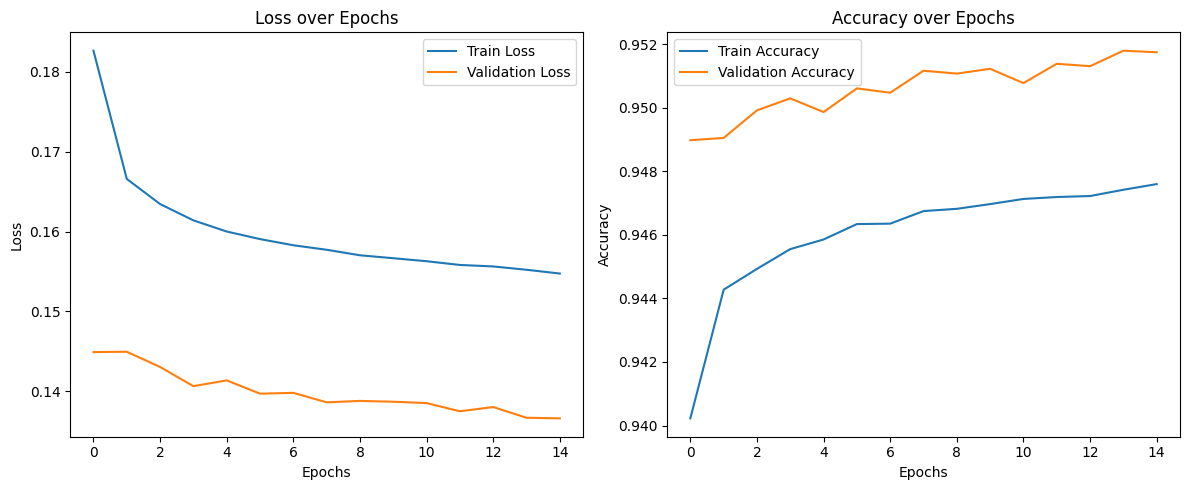

In [75]:
plot_training_history(history)


<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>stable performance</strong> over the epochs, with continuous improvements in both loss and accuracy metrics. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>The <strong>training loss</strong> decreases consistently, while the <strong>validation loss</strong> stabilizes at low levels, indicating efficient model convergence.</li> <li>The <strong>validation accuracy</strong> remains consistently higher than the training accuracy, suggesting that the model generalizes very well to unseen data.</li> <li>The model does not show signs of <strong>overfitting</strong> or <strong>underfitting</strong>, as the loss and accuracy curves maintain a balanced trend.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The analysis reveals that the model is <strong>well-tuned</strong>, achieving solid and consistent performance, with minimal opportunities for further refinement. </blockquote>

11627/11627 ━━━━━━━━━━━━━━━━━━━━ 9s 777us/step


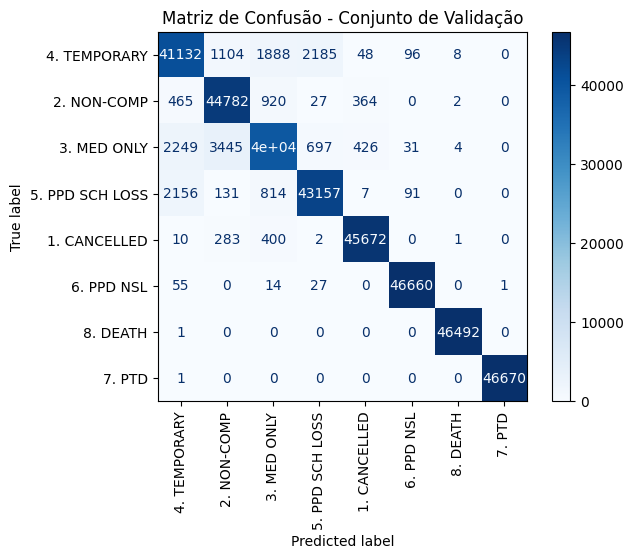

                 precision    recall  f1-score   support

   4. TEMPORARY       0.89      0.89      0.89     46461
    2. NON-COMP       0.90      0.96      0.93     46560
    3. MED ONLY       0.91      0.85      0.88     46378
5. PPD SCH LOSS       0.94      0.93      0.93     46356
   1. CANCELLED       0.98      0.98      0.98     46368
     6. PPD NSL       1.00      1.00      1.00     46757
       8. DEATH       1.00      1.00      1.00     46493
         7. PTD       1.00      1.00      1.00     46671

       accuracy                           0.95    372044
      macro avg       0.95      0.95      0.95    372044
   weighted avg       0.95      0.95      0.95    372044



In [76]:
plot_confusion_matrix(model=nn_model_weight_ensemble, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>exceptional performance</strong> on the validation set, achieving an impressive overall accuracy with highly reliable predictions across most classes. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>Classes like <strong>6. PPD NSL</strong>, <strong>7. PTD</strong>, and <strong>8. DEATH</strong> achieved near-perfect scores with <strong>precision</strong> and <strong>recall</strong> values close to 1.00.</li> <li>The class <strong>4. TEMPORARY</strong> shows slight confusion with classes like <strong>3. MED ONLY</strong> and <strong>5. PPD SCH LOSS</strong>, as seen in the off-diagonal values, but still maintains a high overall recall.</li> <li>Class <strong>3. MED ONLY</strong> exhibits minor misclassifications, suggesting overlapping features with <strong>4. TEMPORARY</strong>, yet it maintains strong predictive performance.</li> <li>Overall, the confusion matrix highlights the model's ability to generalize well across the majority of classes, with very few significant misclassifications.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> This evaluation confirms the model's <strong>robustness</strong> and <strong>reliability</strong>, achieving excellent results across critical classes while demonstrating minor areas for improvement. </blockquote> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The model delivers <strong>high accuracy</strong> and performs exceptionally well, maintaining near-perfect scores in key categories and ensuring strong generalization on unseen data. </blockquote>

In [77]:
save_predictions_to_csv(
    model=nn_model_weight_ensemble,
    test_data=final_test_predictions,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 9s 766us/step
Predições salvas em '../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv'.


In [78]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP     330638
4. TEMPORARY     52956
3. MED ONLY       4381
Name: count, dtype: int64

<h5 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Stacking Ensemble</h5>


In [79]:
X_meta_train = np.column_stack((oof_predictions_rf, oof_predictions_et, oof_predictions_ada, oof_predictions_gnb, oof_predictions_lr))
X_meta_test = np.column_stack((test_predictions_rf, test_predictions_et, test_predictions_ada, test_predictions_gnb, test_predictions_lr))

In [80]:
nn_model_stacking_ensemble, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(X_meta_train, y_train_resampled)

history = nn_model_stacking_ensemble.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_stacking_ensemble, "StackingEnsemble_NN_model")

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Modelo 'StackingEnsemble_NN_model' salvo com sucesso em: ../models/StackingEnsemble_NN_model.pkl


'../models/StackingEnsemble_NN_model.pkl'

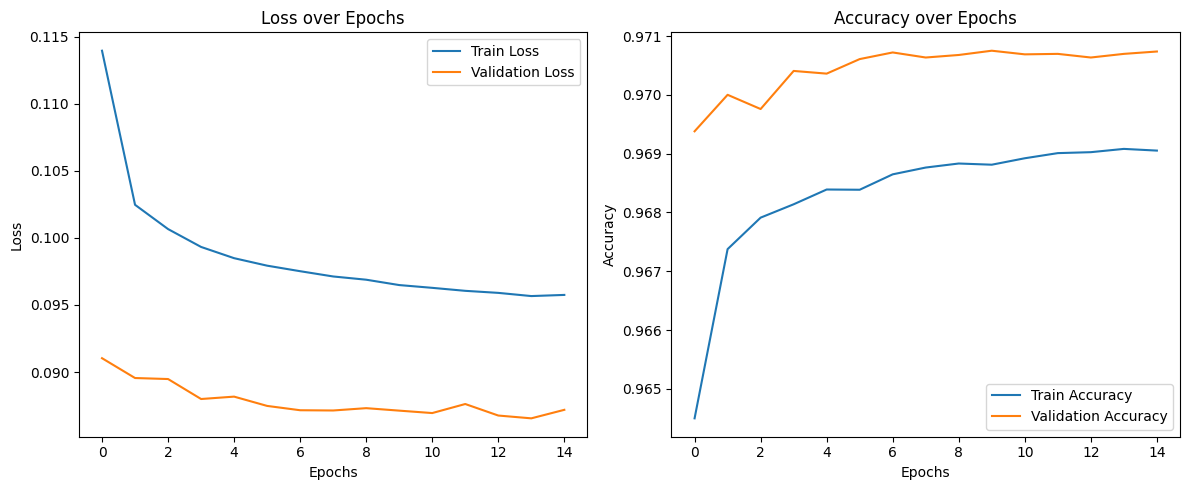

In [81]:
plot_training_history(history)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates a <strong>stable performance</strong> over the epochs, with gradual improvements in both loss and accuracy metrics. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>The <strong>training loss</strong> and <strong>validation loss</strong> exhibit a steady overall reduction, with minor oscillations towards the final epochs, indicating a smooth and consistent learning process.</li> <li>The <strong>validation accuracy</strong> remains consistently higher than the training accuracy, suggesting that the model generalizes well to unseen data.</li> <li>There are no clear signs of <strong>overfitting</strong> or <strong>underfitting</strong>, as both loss and accuracy curves maintain a close alignment throughout the training process.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The analysis highlights a well-tuned and reliable model, achieving strong generalization with minimal opportunities for further improvement. </blockquote>

11627/11627 ━━━━━━━━━━━━━━━━━━━━ 9s 776us/step


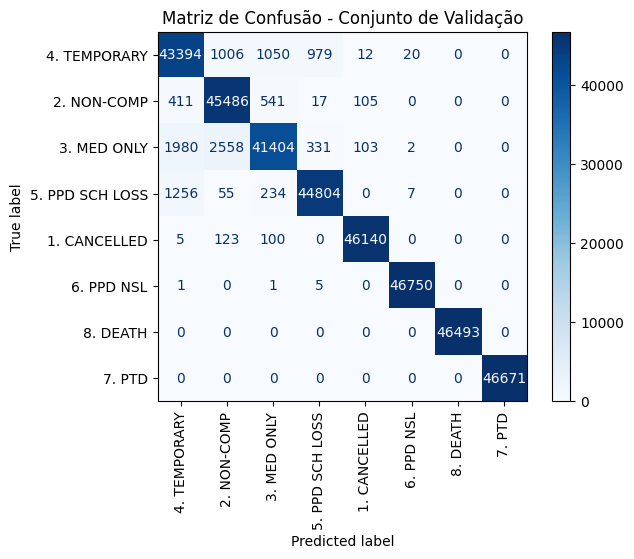

                 precision    recall  f1-score   support

   4. TEMPORARY       0.92      0.93      0.93     46461
    2. NON-COMP       0.92      0.98      0.95     46560
    3. MED ONLY       0.96      0.89      0.92     46378
5. PPD SCH LOSS       0.97      0.97      0.97     46356
   1. CANCELLED       1.00      1.00      1.00     46368
     6. PPD NSL       1.00      1.00      1.00     46757
       8. DEATH       1.00      1.00      1.00     46493
         7. PTD       1.00      1.00      1.00     46671

       accuracy                           0.97    372044
      macro avg       0.97      0.97      0.97    372044
   weighted avg       0.97      0.97      0.97    372044



In [84]:
plot_confusion_matrix(model=nn_model_stacking_ensemble, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> The model demonstrates <strong>exceptional performance</strong> on the validation set, achieving a high overall accuracy of <strong>97%</strong>. Precision, recall, and F1-score are well-balanced across nearly all classes. </p> <ul style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;"> <li>Classes such as <strong>6. PPD NSL</strong>, <strong>7. PTD</strong>, and <strong>8. DEATH</strong> achieved <strong>near-perfect scores</strong> with precision and recall values of 1.00, reflecting their strong predictive performance.</li> <li>The class <strong>3. MED ONLY</strong> shows slightly lower performance, with some confusion observed with class <strong>4. TEMPORARY</strong>, as indicated by its off-diagonal values.</li> <li>Minimal misclassifications are present overall, suggesting that the model is well-calibrated and effectively generalizes to unseen data.</li> </ul> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> This evaluation highlights the model's <strong>robustness</strong> and its ability to achieve consistent, high accuracy across critical classes, with only minor areas for improvement. </blockquote> <blockquote style="font-style:italic; border-left:4px solid #4A90E2; padding-left:10px; margin-left: 0;"> The model delivers <strong>outstanding performance</strong>, with near-perfect results in key categories and minimal confusion, making it highly reliable for real-world applications. </blockquote>

In [82]:
save_predictions_to_csv(
    model=nn_model_stacking_ensemble,
    test_data=X_meta_test,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
Predições salvas em '../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv'.


In [83]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
1. CANCELLED       204806
4. TEMPORARY       173205
3. MED ONLY          6750
2. NON-COMP          2952
5. PPD SCH LOSS       262
Name: count, dtype: int64

<h5 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Models Extra</h5>


<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6;">We ran the CatBoost model together with the Neural Network (NN) model, which gave us the highest score. However, due to errors with TensorFlow, the computer processors, and the BIOS, we were unable to run the model again. As a result of these errors, we lost the best-performing model. But below we give the code for the catboost running</p>

In [ ]:
f1_scores_cb, validation_scores_cb, oof_predictions_cb, test_predictions_cb = meta_model_run(
    model="CatBoost",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

In [ ]:
nn_model_cb, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_cb, y_train_resampled)

history = nn_model_cb.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=5
)

save_model(nn_model_cb, "CatBoost_NN_model")

In [ ]:
plot_training_history(history)

In [ ]:
plot_confusion_matrix(model=nn_model_cb, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

In [ ]:
save_predictions_to_csv(
    model=nn_model_cb,
    test_data=test_predictions_cb,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_CatBoost_NN_predictions.csv"
)


In [ ]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_CatBoost_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values